<SimpleSupplyChain instance>
dim_state:  17
dim_action:  4
action sample:  [13.287947  6.961765 11.565701  7.350364]
step 500 reward:  -15617.37827318736 action:  [-2.91506540e-03 -1.19856903e-02 -6.50677924e-03 -3.86975186e-05]
step 1000 reward:  -15231.817070630588 action:  [ 0.01329944 -0.00430098 -0.01520477 -0.03242073]
step 1500 reward:  -16511.580865392538 action:  [ 0.01276883  0.00690681 -0.01801726  0.02240448]
step 2000 reward:  -15518.852968498502 action:  [ 0.01542549 -0.00781002 -0.00240115  0.01118529]
step 2500 reward:  -15711.735261233018 action:  [ 0.01804878  0.02728275 -0.01565545  0.01623788]
step 3000 reward:  -15317.534593287763 action:  [-0.00847197  0.01216825  0.01422032 -0.00992132]
step 3500 reward:  -15011.800592676922 action:  [0.01847797 0.00651663 0.02418674 0.00653788]
step 4000 reward:  -16711.19487881008 action:  [ 0.01470799  0.02659394  0.02874592 -0.02449145]
step 4500 reward:  -15910.297471995515 action:  [-0.00412629 -0.00646132 -0.0096302  -0.00

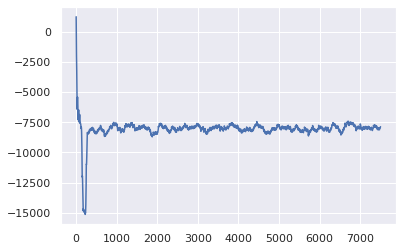

In [2]:
import torch as t
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
import numpy as np
import matplotlib.pyplot as plt
import gym
#import gym_cartpole_swingup  #pip install gym_cartpole_swingup

CUDA_LAUNCH_BLOCKING=1

###################################################
# Deep Deterministic Policy Gradient
###################################################

class Noise():
    def __init__(self,mu,sigma=0.15,theta=0.2,dt=1e-2,x0=None):
        self.theta = theta
        self.mu=mu
        self.sigma = sigma
        self.dt=dt
        self.x0=x0
        self.reset()
    
    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
        self.sigma * np.sqrt(self.dt)*np.random.normal(size=self.mu.shape)
        self.prev = x
        return x
    
    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)
        

class Actor(nn.Module):
    def __init__(self, dim_state, dim_action, fc1, fc2, alpha, min_action, max_action, checkpoint='actor_ddpg_v2' ):
        super(Actor, self).__init__()
        self.dim_state = dim_state
        self.dim_action = dim_action
        self.min_action = min_action
        self.max_action = max_action
        
        self.linear1 = nn.Linear(dim_state, fc1)
        self.linear2 = nn.Linear(fc1, fc2)
        self.linear3 = nn.Linear(fc2, dim_action)
        
        self.device = t.device('cpu' if t.cuda.is_available() else 'cpu')
        self.optimizer = optim.Adam(self.parameters(), lr=alpha, weight_decay=1e-4)
        self.to(self.device)
        self.path = checkpoint
        
    def forward(self, state):
        output = state.to(self.device)
        
        output = f.relu(self.linear1(output))
        output = f.relu(self.linear2(output))
        #output = t.tanh(self.linear3(output)) * self.max_action
        output = t.clamp(self.linear3(output), self.min_action, self.max_action)
        return output
    
    def saveCheckpoint(self):
        print ('...saving check point...')
        t.save(self.state_dict(), self.path)
    
    def loadCheckpoint(self):
        print('...loading check point')
        self.load_state_dict(t.load(self.path))
    
class Critic(nn.Module):   
    def __init__(self, dim_state, dim_action, fc1, fc2, alpha,checkpoint='critic_ddpg_v2'):
        super(Critic, self).__init__()
        self.dim_state = dim_state
        self.dim_action = dim_action
        self.path = checkpoint
        
        self.linear1 = nn.Linear(dim_state+ dim_action, fc1)
        #self.linear2 = nn.Linear(fc1, fc2)
        self.linear3 = nn.Linear(fc1,1)
        self.optimizer = optim.Adam(self.parameters(), lr = alpha, weight_decay=1e-4)
        self.device = t.device('cpu' if t.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self, state, action):
        state = state.to(self.device)
        action = action.to(self.device)
        
        output = t.relu(self.linear1(t.cat((state, action), dim=1)))
        #output = t.relu(self.linear2(output))
        output = self.linear3(output)
        
        return output
    
    def saveCheckpoint(self):
        print('...save checkout...')
        t.save(self.state_dict(), self.path)
    
    def loadCheckpoint(self):
        print ('...load checj point...')
        self.load_state_dict(t.load(self.path))
        
        
class replayBuffer():
    def __init__(self, maxm_size, dim_state, dim_action):
        self.counter = 0
        self.state_mem = np.zeros((maxm_size, dim_state))
        self.action_mem = np.zeros((maxm_size, dim_action))
        self.reward_mem = np.zeros(maxm_size)
        self.state_new_mem = np.zeros((maxm_size, dim_state))
        self.done_mem = np.zeros(maxm_size)
        self.maxm_size = maxm_size
        
    def store_Transaction(self, state, action, reward, state_new, done):
        index = self.counter % self.maxm_size
        
        self.state_mem[index] = state
        self.action_mem[index] = action
        self.reward_mem[index] = reward
        self.state_new_mem[index] =state_new
        self.done_mem[index] = 1.0 - done
        
        self.counter+=1
    
    def sample_batch(self, batch_size=64):
        maxm_size = min(self.counter, self.maxm_size)
        batch = np.random.choice(maxm_size, batch_size)
        
        state_batch = self.state_mem[batch]
        action_batch = self.action_mem[batch]
        reward_batch = self.reward_mem[batch]
        state_new_batch = self.state_new_mem[batch]
        done_batch = self.done_mem[batch]
        
        return state_batch, action_batch,reward_batch,state_new_batch,done_batch
        
    
class Agent():
    def __init__(self, env, dim_state, dim_action, fc1, fc2, alpha, gamma,min_action, max_action, maxm_size, maxm_iters=50, batch_size=64):
        self.dim_state = dim_state
        self.dim_action = dim_action
        self.maxm_iters = maxm_iters
        self.device = t.device('cpu' if t.cuda.is_available() else 'cpu')
        
        self.actor=Actor(dim_state, dim_action, fc1, fc2, alpha, min_action, max_action, checkpoint='actor').to(self.device)
        self.critic=Critic(dim_state, dim_action, fc1, fc2, alpha,checkpoint='critic').to(self.device)
        self.tau = 0.005

        #Initilize the target networks           
        self.actor_t = Actor(dim_state, dim_action, fc1, fc2, alpha, min_action, max_action, checkpoint='actor').to(self.device)
        self.actor_t.load_state_dict(self.actor.state_dict())
        
        self.critic_t = Critic(dim_state, dim_action, fc1, fc2, alpha,checkpoint='critic').to(self.device)
        self.critic_t.load_state_dict(self.critic.state_dict())
        
        self.buffer = replayBuffer(maxm_size, dim_state, dim_action) # maxm_size, dim_state, dim_action):
        self.gamma = gamma
        self.batch_size = batch_size   
        self.noise = Noise(mu=np.zeros(dim_action))
        self.loss = nn.MSELoss()
        self.env = env
        
        
    def plot_learning_curve(self,x, scores, figure_file='test'):
        running_avg = np.zeros(len(scores))
        for i in range(len(running_avg)):
            running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
        plt.plot(x, running_avg)
        #plt.title('Running average of previous 100 scores')
        plt.savefig('ddpg_v2.png')
        
    def update_parms(self):
        
        critic_dict = dict(self.critic_t.named_parameters())
        critic_t_dict = dict(self.critic.named_parameters())
        
        actor_t_dict = dict(self.actor_t.named_parameters())
        actor_dict = dict(self.actor.named_parameters())
        
        #Update the critic
        for i in critic_dict:
            critic_dict[i] = self.tau*critic_dict[i].clone() + (1-self.tau)*critic_t_dict[i].clone()
        self.critic_t.load_state_dict(critic_dict)
        
        #Update the actor
        for j in actor_dict:
            actor_dict[j] = self.tau*actor_dict[j].clone() + (1-self.tau)*actor_t_dict[j].clone()
        self.actor_t.load_state_dict(actor_dict)
           
    def learn(self):

        reward_list = []  
        reward_list_n= []
        n=0
           
        for i in range(self.maxm_iters):
            self.noise.reset()
            
            done= False
            state = self.env.reset()       
            total_reward= 0
            
            while not done:   
                n+=1
                self.critic.train()
                self.actor.train()
                
                self.critic.optimizer.zero_grad()
                self.actor.optimizer.zero_grad()
                
                action = self.actor(t.tensor(state).float().to(self.device)).cpu().detach().numpy() + self.noise()
                if n % 200 == 0:
                    #print(f'action {n}: ', action)
                    pass

                state_new, reward, done, _ = self.env.step(action)
                reward_list_n.append(reward)
                total_reward+=reward
        
                self.buffer.store_Transaction(state, action, reward, state_new, done)

                if self.buffer.counter >= self.batch_size:
                    state_batch, action_batch, reward_batch, state_new_batch, done_batch = self.buffer.sample_batch()
                    
                    state_batch = t.tensor(state_batch, dtype=t.float).to(self.actor.device)
                    action_batch = t.tensor(action_batch, dtype=t.float).to(self.actor.device)
                    reward_batch = t.tensor(reward_batch, dtype=t.float).to(self.actor.device).view(-1,1)
                    state_new_batch = t.tensor(state_new_batch, dtype=t.float).to(self.actor.device)
                    done_batch = t.tensor(done_batch, dtype=t.float).to(self.actor.device).view(-1,1)                    
                        
                    ##Update the critic
                    with t.no_grad():
                        #target = t.tensor(reward_batch)  
                        target = reward_batch.clone().detach()
                        target += self.gamma*self.critic_t(state_new_batch,self.actor_t(state_new_batch))*done_batch
                    preds = self.critic(state_batch, action_batch)

                    loss_critic = self.loss(target, preds)
                    loss_critic.backward()
                    self.critic.optimizer.step()
        
                    ##Update the actor
                    loss_actor = -self.critic(state_batch, self.actor(state_batch))
                    loss_actor = loss_actor.mean()
                    loss_actor.backward()                    
                    self.actor.optimizer.step()                    
                    
                    self.update_parms()
        
                state = state_new
                if n % 500 ==0:
                    print(f'step {n} reward: ', reward, f'action: ', action,)
                    #print('State: ', state, type(state))
                    pass
            reward_list.append(total_reward)
        
        #x = [i+1 for i in range(self.maxm_iters)]
        #self.plot_learning_curve(x, reward_list)
        x = [i+1 for i in range(n)]
        self.plot_learning_curve(x, reward_list_n)
        
        
if __name__ == '__main__':
    """
    env = gym.make('Pendulum-v0')
    #env = or_gym.make('CartPoleSwingUp-v0')
    #env = gym.make('MountainCar-v0')
    dim_state = env.observation_space.shape[0]
    dim_action = env.action_space.shape[0]
    print(dim_state, dim_action)
    print('space sample: ', env.observation_space.sample())
    print('action sample: ', env.action_space.sample())
    agent = Agent(env,dim_state,dim_action, 256, 256, 1e-5, 0.99, 3000, maxm_iters=1000)
    agent.train()
    """
    from Envs import SupplyChain as e
    import importlib
    importlib.reload(e)

    env = e.SimpleSupplyChain()
    print(env)
    dim_state = env.observation_space.shape[0]
    dim_action = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])
    min_action = float(env.action_space.low[0])
    print('dim_state: ', dim_state)
    print ('dim_action: ', dim_action)
    print('action sample: ', env.action_space.sample())
    agent = Agent(env,dim_state,dim_action, 200, 100, 2e-3, 0.99,min_action, max_action, 100000, maxm_iters=300)
    agent.learn()
    agent.actor.saveCheckpoint()
    agent.critic.saveCheckpoint()
    
